In [1]:
import os
import jax
import pickle

os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=24'
jax.config.update('jax_platform_name', 'cpu')

#from jax.config import config; config.update("jax_enable_x64", True)

%load_ext autoreload
%autoreload 2

from brax import envs
from brax.io import html, model
from brax.training import normalization

import flax
import jax.numpy as jnp
from brax.envs import create_fn

from IPython.display import HTML, clear_output

import optax

import matplotlib.pyplot as plt
import numpy as np

from controllers import GruController, MlpController, LinearController

from ce_apg import do_one_rollout, cem_apg

from functools import partial

def visualize(sys, qps, height=480):
  """Renders a 3D visualization of the environment."""
  return HTML(html.render(sys, qps, height=height))

len(jax.devices())

save_dir = "save_ce_apg4"

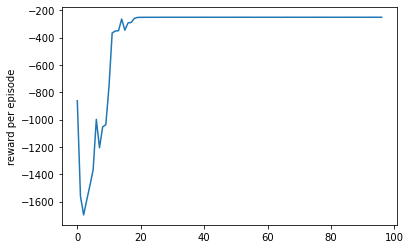

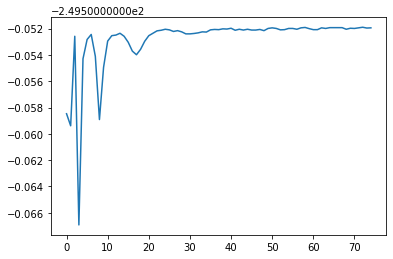

 Iteration 96 --------------------------------
0 : reward: -288.4111328125 -> -249.5519561767578
1 : reward: -249.7472381591797 -> -249.59072875976562
2 : reward: -372.970947265625 -> -249.6409149169922
3 : reward: -250.04827880859375 -> -249.682373046875
4 : reward: -249.8563232421875 -> -249.68309020996094
5 : reward: -249.72915649414062 -> -249.6837615966797
6 : reward: -249.816650390625 -> -249.79312133789062
7 : reward: -269.1968078613281 -> -249.8186798095703
---
8 : reward: -249.763427734375 -> -249.853271484375
9 : reward: -249.9248046875 -> -249.89663696289062
10 : reward: -249.753662109375 -> -249.8992919921875
11 : reward: -251.51441955566406 -> -249.93357849121094
12 : reward: -250.1613311767578 -> -250.00718688964844
13 : reward: -250.49118041992188 -> -250.0293426513672
14 : reward: -250.11119079589844 -> -250.05859375
15 : reward: -288.8274841308594 -> -250.1104278564453
16 : reward: -289.0204162597656 -> -250.4546661376953
17 : reward: -249.81753540039062 -> -269.455383

Exception: NaNs detected in elite params

In [2]:
env_name = "reacher"  # @param ['ant', 'humanoid', 'fetch', 'grasp', 'halfcheetah', 'walker2d, 'ur5e', 'reacher', bball_1dof]

for env_name in ["inverted_pendulum_swingup" , "acrobot", "inverted_double_pendulum_swingup"]:  # @param ['ant', 'humanoid', 'fetch', 'grasp', 'halfcheetah', 'walker2d, 'ur5e', 'reacher', bball_1dof]

    episode_length = 500
    action_repeat = 1
    env_fn = create_fn(env_name = env_name, action_repeat=action_repeat, batch_size=None, auto_reset=False)
    env = env_fn()

    policy_size = int(2**jnp.ceil(jnp.log2(env.observation_size*4)))
    print(policy_size)
    policy = GruController(env.observation_size, env.action_size, policy_size)
    pickle.dump(policy, open(f"{save_dir}/{env_name}_policy", 'wb'))
    
    for i in range(8):
        inference_fn, params, rewards = cem_apg(env_fn,
                                                200,
                                                key=jax.random.PRNGKey(i),
                                                episode_length = episode_length,
                                                action_repeat = action_repeat,
                                                apg_epochs = 75,
                                                batch_size = 1,
                                                truncation_length = None,
                                                learning_rate = 5e-4,
                                                clipping = 1e9,
                                                initial_std = 0.05,
                                                num_elite = 8,
                                                eps = 0.0,
                                                normalize_observations=True,
                                                policy = policy
                                               )

        model.save_params(f"{save_dir}/{env_name}_params_{i}", params)
        pickle.dump(rewards, open(f"{save_dir}/{env_name}_rewards.pkl{i}", "wb"))



In [ ]:
from brax.io import model
import ce_apg

model.save_params('/tmp/params', params)
inference_fn = ce_apg.make_inference_fn(
    env.observation_size, env.action_size, True, policy)
params = model.load_params('/tmp/params')

jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

rollout = []
rng = jax.random.PRNGKey(seed=5)
state = jit_env_reset(rng=rng)
h0 = np.zeros_like(state.obs)
h = h0

while not state.done:
  rollout.append(state)
  h, act = jit_inference_fn(params, h, state.obs)
  state = jit_env_step(state, act)

HTML(html.render(env.sys, [s.qp for s in rollout]))

In [ ]:
env_name = "acrobot"  # @param ['ant', 'humanoid', 'fetch', 'grasp', 'halfcheetah', 'walker2d, 'ur5e', 'reacher', bball_1dof]

episode_length = 500
action_repeat = 1
env_fn = create_fn(env_name = env_name, action_repeat=action_repeat, batch_size=None, auto_reset=False)
env = env_fn()



policy_size = int(2**jnp.ceil(jnp.log2(env.observation_size*4)))
print(policy_size)
policy = GruController(env.observation_size, env.action_size, 32)

for i in range(8):
    normalizer_params, policy_params, rewards = cem_apg(env_fn,
                                                        200,
                                                        key=jax.random.PRNGKey(i),
                                                        episode_length = episode_length,
                                                        action_repeat = action_repeat,
                                                        apg_epochs = 75,
                                                        cem_epochs = 1,
                                                        batch_size = 1,
                                                        truncation_length = None,
                                                        learning_rate = 5e-4,
                                                        clipping = 1e9,
                                                        initial_std = 0.01,
                                                        num_elite = 8,
                                                        eps = 0.0,
                                                        normalize_observations=True,
                                                        policy = policy
                                                       )



    pickle.dump(policy_params, open(f"{save_dir}/{env_name}_policy{i}.pkl", 'wb'))
    pickle.dump(normalizer_params, open(f"{save_dir}/{env_name}_normalize{i}.pkl", 'wb'))
    pickle.dump(rewards, open(f"{save_dir}/{env_name}_rewards.pkl{i}", 'wb'))

In [ ]:
env_name = "inverted_double_pendulum_swingup"  # @param ['ant', 'humanoid', 'fetch', 'grasp', 'halfcheetah', 'walker2d, 'ur5e', 'reacher', bball_1dof]

episode_length = 500
action_repeat = 1
env_fn = create_fn(env_name = env_name, action_repeat=action_repeat, batch_size=None, auto_reset=False)
env = env_fn()



policy_size = int(2**jnp.ceil(jnp.log2(env.observation_size*4)))
print(policy_size)
policy = GruController(env.observation_size, env.action_size, 128)

for i in range(8):
    normalizer_params, policy_params, rewards = cem_apg(env_fn,
                                                        200,
                                                        key=jax.random.PRNGKey(i),
                                                        episode_length = episode_length,
                                                        action_repeat = action_repeat,
                                                        apg_epochs = 75,
                                                        cem_epochs = 1,
                                                        batch_size = 1,
                                                        truncation_length = None,
                                                        learning_rate = 5e-4,
                                                        clipping = 1e9,
                                                        initial_std = 0.01,
                                                        num_elite = 8,
                                                        eps = 0.0,
                                                        normalize_observations=True,
                                                        policy = policy
                                                       )



    pickle.dump(policy_params, open(f"{save_dir}/{env_name}_policy{i}.pkl", 'wb'))
    pickle.dump(normalizer_params, open(f"{save_dir}/{env_name}_normalize{i}.pkl", 'wb'))
    pickle.dump(rewards, open(f"{save_dir}/{env_name}_rewards.pkl{i}", 'wb'))

In [ ]:
import pickle
pickle.dump(policy_params2, open("inverted_double_pendulum_swingup.pickle", 'wb'))

In [ ]:
env_name = "inverted_double_pendulum_swingup"
pickle.dump(policy_params2, open(f"{env_name}_policy.pkl", 'wb'))
pickle.dump(normalizer_params2, open(f"{env_name}_normalize.pkl", 'wb'))
pickle.dump(rewards2, open(f"{env_name}_rewards.pkl", 'wb'))